# Theory of L2 and L1 Regression and Regularization

## Data Science 410

In this notebook we will continue our exploration of the mathematical basis of linear statistical models. The emphasis is on the ubiquitous problem of **model over-fitting** or **model over-parameterization**. 

Over-fitting (or over-parameterization) of machine learning models arises in any case where the number of model parameters exceeds the effective dimensions of the feature set. This is most often the result of linear dependency between the features. However, using too complex a model can lead to similar problems. In the extreme case, imagine a model with as many free parameters as training cases. This model might fit the training data perfectly, but will show unstable and unexpected results when used for other data. In machine learning terminology, we say that such an unstable model does not **generalize**. 

Many methods have been developed and continue to be developed to deal with over-parameterized or **ill-posed** machine learning models. In particular, we will explore three methods for stabilizing over-parameterized models: 

- Stepwise regression, wherein features are eliminated from an over-parameterized model in a stepwise fashion. 
- Using a mathematical **regularization** technique, known as singular value decomposition, to determine the number of meaningful components for a model. We will explore use of singular value decomposition in another notebook. 
- Using **regularization** methods known as ridge, lasso, and elastic-net regression to stabilize over-parameterized models. We will explore ridge and lasso regression in this notebook.


## Load Packages

Execute the code in the cell below to import the packages you will need for the rest of this notebook.  

In [1]:
import pandas as pd
import numpy as np
import numpy.random as nr
import statsmodels.formula.api as sm
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Review of Eigenvalue Decomposition

Before we address regularization we will review **eigendecomposition** of matrices. **Eigenvalues** are characteristic roots or characteristic values of a linear system of equations. The eigendecomposition is a factorization of the a matrix. 

Let's start with a **square matrix**, $A$:

$$A = 
\begin{bmatrix}
   a_{11}  & a_{12} & \dots & a_{1n} \\
    a_{21}  & a_{22} & \dots & a_{2n} \\
    \vdots &\vdots &\vdots & \vdots \\
    a_{n1} & a_{n2} &  \dots & a_{nn}
\end{bmatrix}$$

Next define a vector, $x$: 

$$x = 
\begin{bmatrix}
   x_{1}\\
    x_{2}\\
    \vdots\\
    x_{n}
\end{bmatrix}$$

Then an **eigenvalue**, $\lambda$ and **eigenvector**, $x$, of the matrix $A$ have the property: 

$$A x = \lambda x$$

Or,   

$$
\begin{bmatrix}
   a_{11}  & a_{12} & \dots & a_{1n} \\
    a_{21}  & a_{22} & \dots & a_{2n} \\
    \vdots &\vdots &\vdots & \vdots \\
    a_{n1} & a_{n2} &  \dots & a_{nn}
\end{bmatrix}  
\begin{bmatrix}
   x_{1}\\
    x_{2}\\
    \vdots\\
    x_{n}
\end{bmatrix} 
= 
\lambda 
\begin{bmatrix}
   x_{1}\\
    x_{2}\\
    \vdots\\
    x_{n}
\end{bmatrix}
$$


To see that the eigenvalue, $\lambda$, is a root of the matrix, $A$ we can rearrange the above as follows:   

\begin{align}
Ax - \lambda x &= 0 \\
(A - I \lambda) x &= 0
\end{align}

Where, $I$ is the **identity matrix** of 1 on the diagonal and 0 elsewhere. These relationships can be written as follows:  

$$
\begin{bmatrix}
   a_{11} - \lambda  & a_{12} & \dots & a_{1n} \\
    a_{21}  & a_{22} - \lambda  & \dots & a_{2n} \\
    \vdots &\vdots &\vdots & \vdots \\
    a_{n1} & a_{n2} &  \dots & a_{nn} - \lambda 
\end{bmatrix}  
\begin{bmatrix}
   x_{1}\\
    x_{2}\\
    \vdots\\
    x_{n}
\end{bmatrix} 
= 
\begin{bmatrix}
   x_{1}\\
    x_{2}\\
    \vdots\\
    x_{n}
\end{bmatrix}
$$


The foregoing show that the eigenvalue, $\lambda$, is a **root of the matrix, $A$**. 

For an $n\ x\ n$ matrix, $A$, there are $n$ eigenvalues or roots. These can be found by solving the following equation, using the determinant:  

$$det(A - x) = 0$$



Using these eigenvalues we can factor a square $n\ x\ n$ matrix, $A$ into eigenvectors and eigenvalues. Represent the matrix of eigenvectors as $Q$ and the diagonal matrix of n eigenvalues as $\Lambda$:

$$A = Q \Lambda Q^{-1}$$

Where $Q^{-1}$ is the inverse of the eigenvector matrix. The eigenvectors have norm 1, makeing the eigenvector matrices, $Q$, **unitary**.  

Using the eigenvalue-eigenvector decompositions, the inverse of a square $n\ x\ n$ matrix can be expressed:

$$A^{-1} = Q \Lambda^{-1} Q^{-1}$$  

In fact, since the matrix of eigenvectors is unitary, we can compute the value of the matrix $A$ to the Nth power as:

$$A^{N} = Q \Lambda^{N} Q^{-1}$$

You can find more information on the properties of eigenvalue-eigenvector decomposition in this [article](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix).

## Regularization with Ridge Regression, L2

So far, we have looked at two approached for dealing with over-parameterized models; feature selection by stepwise regression and singular value decomposition. In this section we will explore the most widely used regularization method for optimization-based machine learning models, ridge regression. 



### Review of Normal Equations   

Let's start by reviewing the **normal equation** formulation of the linear regression problem. The goal is to compute a vector of **model coefficients**, $b$, or weights which minimize the mean squared **residuals**, $\epsilon$, given a vector of data $x$ and a **model matrix** $A$. We can write our model as:

$$x = A b + \epsilon$$

To solve this problem we would ideally like to compute:

$$b = A^{-1}x$$

The commonly used Normal Equation form can help:

$$b = (A^TA)^{-1}A^Tx$$

Now, $A^TA$ is an $m x m$ matrix, and thus is of reduced dimension. But, **$A^TA$ can still be rank deficient!** 



### Covariance of the Model Matrix

There is a simple and useful relationship between the **covariance matrix** of $A$ and $A^T A$:  

$$cov(A) = \frac{1}{n} A^T A$$

The question is, how can we use the covariance matrix to evaluate our ability to find an invoice? The answer is to examine the eigenvalues of the covariance matrix.  

A covariance matrix of a real valued matrix $A$ is **square** and **symmetric**. This means we can perform **eigendecomposition** on the covariance matrix. 

$$cov(A) = Q \Lambda Q^{-1}$$

where,   
$Q$ is the unitary matrix of eigenvectors.
$\Lambda$ is the diagonal matrix of eigenvalues, defining the **spectrum** of the covariance matrix.

### The L2 Regularization Approach

The basic idea of ridge regression is to stabilize the **inverse covariance matrix**, $D^+=(A^{T}A)^{-1}$, by **adding a small bias term**, $\alpha$, to each of the eigenvalues. We can state this operation in matrix notation as follows. We start with a modified form of the normal equations (also know as the **L2 or Euclidean norm** minimization problem):

$$min [\parallel A \cdot x - b \parallel +\ \alpha \parallel b\parallel]\\  or \\
b = (A^TA + \alpha^2)^{-1}A^Tx$$

But, what does it mean that we are using an L2 or Euclidean norm as for regularization? The answer is that we constrain the L2 norm values of the model coefficients using the **penalty term** $\alpha \parallel b\parallel$. The norm of the model coefficients $\parallel b\parallel$ is the L2 norm of the model parameter values for $m$ model parameters:

$$||b|| = \big( b_1^2 + b_2^2 + \ldots + b_m^2 \big)^{\frac{1}{2}} = \Big( \sum_{i=1}^m b_i^2 \Big)^{\frac{1}{2}}$$


In this way, the values of small singular values do not blow up when we compute the inverse. You can see this by writing out the $\Lambda^+$ matrix of the eigenvalues of the covariance matrix with the bias term.

$$\Lambda_{ridge}^+  = \begin{bmatrix}
    \frac{1}{\lambda_1 + \alpha^2}  & 0 & 0 & \dots & 0 \\
    0  & \frac{1}{\lambda_2 + \alpha^2} & 0 & \dots & 0 \\
    \vdots &\vdots &\vdots & & \vdots \\
    0 & 0 & 0 & \dots & \frac{1}{\lambda_m + \alpha^2}
\end{bmatrix}$$

Adding this bias term creates a 'ridge' in the singular value matrix, giving this method its name **ridge regression**. 

You can also think of ridge regression as limiting the L2 or Euclidean norm of the values of the model coefficient vector. The value of $\alpha$ determines how much the norm of the coefficient vector constrains the solution. You can see a view of this geometric interpretation in the figure below.  

![](img/L2.jpg)
<center> **Geometric view of L2 regularization**</center>
    
From the above figure, you can see that L2 regularization is a **soft constraint**. The overall Euclidean norm of the model parameter values is constrained. This soft constraint does not force any parameter value to exactly 0. 

The same method goes by some other names, as it seems to have been 'invented' several times. In particular, **Tikhonov regularization**, or **L2 norm regularization**. In all likelihood the method was first developed by the Russian mathematician Andrey Tikhonov in the late 1940's, and first published in English in 1977.

![](img/Tikhonov_board.jpg)
<center> **Commemorative plaque for Andrey Nikolayevich Tikhonov at Moscow State University**

Let's give this a try. Execute the code in the cell below which computes the $(A^TA + \lambda^2)^{-1}A^T$ matrix with a lambda value of `0.1`.

### Example of Regularized Covariance

The foregoing is rather abstract. How can you understand the practical implications of l2 regularization? Let's try an exercise to compute and understand the eigenvalues of the covariance of the Gaulton families data. 

As a first step execute the code in the cell below to do the following:     
- Load the dataset into a data frame.
- Compute some features for the model.
- Subset the data to male adult children. 
- Scale the features. 

In [3]:
def scale(col):
    mean_col = np.mean(col)
    sd_col = np.std(col)
    std = (col - mean_col) / sd_col
    return std

gaulton = pd.read_csv('GaltonFamilies.csv')

gaulton.loc[:,'mother_sqr'] = np.square(gaulton.loc[:,'mother'])
gaulton.loc[:,'father_sqr'] = np.square(gaulton.loc[:,'father'])
gaulton.loc[:,'mother_father'] = np.multiply(gaulton.loc[:,'mother'],gaulton.loc[:,'father'])

gaulton_male = gaulton.loc[gaulton.gender == 'male']

for col in ['mother','father','midparentHeight','children','mother_sqr','father_sqr', 'mother_father']:
    gaulton_male.loc[:,col] = scale(gaulton_male.loc[:,col])
    
gaulton_male.head(10)    

C:\Users\StevePC2\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,Unnamed: 0,family,father,mother,midparentHeight,children,childNum,gender,childHeight,mother_sqr,father_sqr,mother_father
0,1,1,4.064643,1.279202,3.541752,-0.753171,1,male,73.2,1.297194,4.313671,3.653347
4,5,2,2.762202,1.063611,2.544031,-0.753171,1,male,73.5,1.071330,2.866312,2.604890
5,6,2,2.762202,1.063611,2.544031,-0.753171,2,male,72.5,1.071330,2.866312,2.604890
8,9,3,2.545129,-0.014343,1.642137,-1.503223,1,male,71.0,-0.032611,2.630568,1.635480
10,11,4,2.545129,-0.014343,1.642137,-0.378145,1,male,70.5,-0.032611,2.630568,1.635480
11,12,4,2.545129,-0.014343,1.642137,-0.378145,2,male,68.5,-0.032611,2.630568,1.635480
15,16,5,2.545129,-2.385842,-0.032005,-0.003119,1,male,72.0,-2.312397,2.630568,-0.175989
16,17,5,2.545129,-2.385842,-0.032005,-0.003119,2,male,69.0,-2.312397,2.630568,-0.175989
17,18,5,2.545129,-2.385842,-0.032005,-0.003119,3,male,68.0,-2.312397,2.630568,-0.175989
22,23,7,2.110982,1.710384,2.577852,-0.003119,1,male,76.5,1.753997,2.163779,2.654294


The code in the cell below computes the covariance matrix of the features, or design matrix. Execute the code and examine the result. 

In [113]:
X = gaulton_male.loc[:,['mother','father','midparentHeight','children','mother_sqr','father_sqr','mother_father']]

C = np.dot(np.transpose(X),X)
C = np.multiply(1.0/float(X.shape[0]), C)
np.round(C,2)

array([[ 1.  ,  0.09,  0.76, -0.01,  1.  ,  0.09,  0.76],
       [ 0.09,  1.  ,  0.71, -0.1 ,  0.09,  1.  ,  0.71],
       [ 0.76,  0.71,  1.  , -0.07,  0.76,  0.71,  1.  ],
       [-0.01, -0.1 , -0.07,  1.  , -0.01, -0.1 , -0.07],
       [ 1.  ,  0.09,  0.76, -0.01,  1.  ,  0.09,  0.76],
       [ 0.09,  1.  ,  0.71, -0.1 ,  0.09,  1.  ,  0.71],
       [ 0.76,  0.71,  1.  , -0.07,  0.76,  0.71,  1.  ]])

Notice that covariance matrix is symmetric about the diagonal. Also, notice the there are several off-diagonal terms with value of 1.0, indicating that inverting this matrix will be mathematically unstable. 

Execute the code in the cell below and examine the eigenvalues of the covariance matrix. 

In [114]:
L, Q = np.linalg.eig(C)
np.round(L,4)

array([4.1827e+00, 1.8336e+00, 9.8240e-01, 0.0000e+00, 3.0000e-04,
       4.0000e-04, 6.0000e-04])

Several of these eigenvalues are effectively 0, confirming the inverse of the covariance matrix will be unstable. 

The code in the cell below adds a small amount of bias to the covariance matrix. Execute the code and examine the result. 

In [115]:
alpha = 0.01
for i in range(C.shape[0]):
    C[i,i] = C[i,i] + alpha
np.round(C,2)

array([[ 1.01,  0.09,  0.76, -0.01,  1.  ,  0.09,  0.76],
       [ 0.09,  1.01,  0.71, -0.1 ,  0.09,  1.  ,  0.71],
       [ 0.76,  0.71,  1.01, -0.07,  0.76,  0.71,  1.  ],
       [-0.01, -0.1 , -0.07,  1.01, -0.01, -0.1 , -0.07],
       [ 1.  ,  0.09,  0.76, -0.01,  1.01,  0.09,  0.76],
       [ 0.09,  1.  ,  0.71, -0.1 ,  0.09,  1.01,  0.71],
       [ 0.76,  0.71,  1.  , -0.07,  0.76,  0.71,  1.01]])

Execute the code in the cell below to compute and display the eigenvalues of the biased covariance matrix. 

In [116]:
L_regularized, Q = np.linalg.eig(C)
np.round(L_regularized,4)

array([4.1927, 1.8436, 0.9924, 0.01  , 0.0103, 0.0104, 0.0106])

Notice that none of these eigenvalues is 0 anymore. Apparently a small amount of bias has stabilized the inverse of the covariance matrix.   

How different are these eigenvalues from the unbiased estimates? Execute the code in the cell below to find out.  

In [118]:
np.round(np.subtract(L_regularized,L),3)

array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])

The difference in the eigenvalues is minimal and equal to the value of the bias added. 

### Regression with L2 Regularization

We are ready to try an example. We will perform regression on the subset of the Gaulton family dataset. 

The statsmodels package allows us to compute a sequence of ridge regression solutions. The code in the cell below computes solutions for a series of values of $\alpha$. The L1_wt argument of the fit_regularized method is set to 0.0, making this L2 regularized or ridge regression. 

The function in the cell below computes a regularized linear regression model for each of a series of values of the regularization parameter, $\alpha$. For each value of $\alpha$, the model parameters, or partial slope parameters, are stored in an array, which is returned. Execute this code and examine the first few values of the model coefficients as $\alpha$ increases.

In [130]:
def regularized_coefs(df, alphas, L1_wt=0.0, n_coefs=7,
                      formula = 'childHeight ~ mother + father + midparentHeight + children + mother_sqr + father_sqr + mother_father'):
    '''Function that computes a linear model for each value of the regualarization 
    parameter alpha and returns an array of the coefficient values. The L1_wt 
    determines the trade-off between L1 and L2 regualarization'''
    coefs = np.zeros((len(alphas),n_coefs + 1))
    for i,alpha in enumerate(alphas):
        temp_mod = sm.ols(formula, data=df).fit_regularized(alpha=alpha,L1_wt=L1_wt)
        coefs[i,:] = temp_mod.params
    return coefs

alphas = np.arange(0.05, 20.0, step = 0.1)
#formula = 'childHeight ~ mother + father + mother_sqr + father_sqr'
coefs = regularized_coefs(gaulton_male, alphas)
coefs[:5]

array([[65.93723394,  0.14702505,  0.28386413,  0.28807185, -0.18799426,
         0.18452878,  0.25463985,  0.31386057],
       [60.20356142,  0.15922578,  0.26868147,  0.28682849, -0.17372119,
         0.17186296,  0.25921507,  0.29537891],
       [55.38727651,  0.15966439,  0.26009875,  0.28156634, -0.16167729,
         0.1673123 ,  0.25458184,  0.28665077],
       [51.28451528,  0.15843001,  0.25277663,  0.27594152, -0.15134125,
         0.16394023,  0.24894127,  0.27954241],
       [47.74765216,  0.15665672,  0.24609669,  0.27035316, -0.14236104,
         0.16097998,  0.24318774,  0.27313201]])

The first parameter, the intercept term, is the largest. Notice how all the parameter values decrease as $\alpha$ increases. 

The function in the cell below plots each of the partial slopes vs. the regularization parameter. Execute this code and examine the plot. 

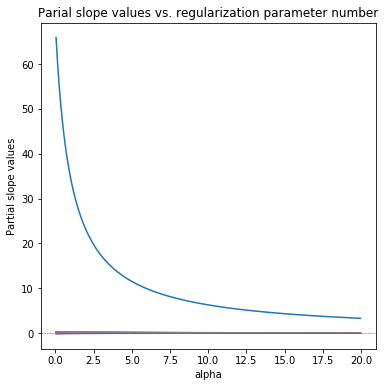

In [135]:
def plot_coefs(coefs, alphas, ylim=None):
    ax = plt.figure(figsize=(6, 6)).gca() # define axis
    for i in range(coefs.shape[1]): # Iterate over coefficients
        ax.plot(alphas, coefs[:,i])
    ax.axhline(0.0, color='red', linestyle='--', linewidth=0.5)
    ax.set_ylabel('Partial slope values')
    ax.set_xlabel('alpha')
    ax.set_title('Parial slope values vs. regularization parameter number')
    if ylim is not None: ax.set_ylim(ylim)

plot_coefs(coefs, alphas)

There is one parameter, the intercept, which is far from zero. The other parameters all have values near zero. 

Keep in mind that the height of the adult male children regresses to the mean, which is the intercept value. Initially, the intercept value is close to the mean of the heights. As the regularization parameter increases, so does the bias.  

Execute the code in the cell below to examine the smaller model parameters.  

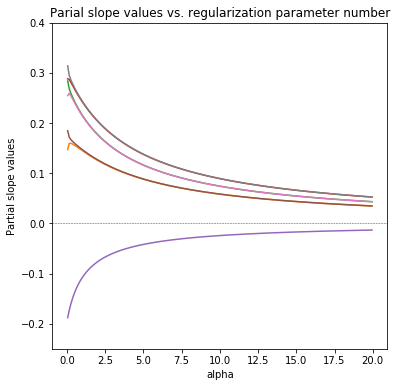

In [136]:
plot_coefs(coefs, alphas, ylim=(-0.25,0.4))

Notice that as the regularization parameter increases, the model parameters are driven toward 0. The trend is smooth, consistent with the soft constraint property of L2 regularization. 

## Lasso regression. L1

We can also do regularization using other norms. **Lasso or L1 regularization** limits the sum of the absolute values of the model coefficients. The L1 norm is sometime know as the **Manhattan norm**, since distance is measured as if you were traveling on a rectangular grid of streets. 

The L1 regularized linear model can be written as:

$$min [\parallel A \cdot x - b \parallel +\ \alpha \parallel b\parallel^1]$$

This looks a lot like the L2 regularization formulation. However, the norm of the model parameters is now, $\parallel b\parallel^1$, indicating an L1 norm. We can compute the l1 norm of the $m$ model parameters:

$$||b||^1 = \big( |b_1| + |b_2| + \ldots + |b_m| \big) = \Big( \sum_{i=1}^m |b_i| \Big)^1$$

where $|b_i|$ is the absolute value of $b_i$. 

You can also think of lasso regression as limiting the L1 norm of the values of the model coefficients. The value of $\alpha$ determines how much the norm of the coefficient values constrains the solution. You can see a view of this geometric interpretation in the figure below.  

![](img/L1.jpg)
<center> Geometric view of L1 regularization </center>

The L1 norm is a **hard constraint** on the parameter values. The L1 norm will force model parameter values to 0. 

The behavior of the L1 norm means that the solution of the regression problem is no longer linear. This makes the computation of lasso models more computationally intensive than ridge regression or L2 regularized models. 

### Example of L1 Regularization

With some theory in mind, it is time to try an example of L1 regularization. The code in the cell below uses the same function as before to create an array of model parameter values as the regularization parameter increases. Execute this code and examine the head of the model parameter array. 

In [125]:
alphas = np.arange(0.05, 2.0, step = 0.02)
coefs = regularized_coefs(gaulton_male, alphas, L1_wt=1.0)
coefs[:5]

array([[ 6.91840956e+01,  3.73253287e-02,  2.77392672e-01,
         9.09067649e-01, -1.49348191e-01,  0.00000000e+00,
         0.00000000e+00,  7.16532354e-02],
       [ 6.91640956e+01,  0.00000000e+00,  2.04337773e-01,
         9.71771706e-01, -1.32580522e-01,  0.00000000e+00,
         0.00000000e+00,  7.05166620e-02],
       [ 6.91440956e+01,  0.00000000e+00,  1.94488921e-01,
         9.61033312e-01, -1.14376048e-01,  0.00000000e+00,
         0.00000000e+00,  6.95085013e-02],
       [ 6.91240956e+01,  0.00000000e+00,  1.84652155e-01,
         9.50286724e-01, -9.61709706e-02,  0.00000000e+00,
         0.00000000e+00,  6.84999813e-02],
       [ 6.91040956e+01,  0.00000000e+00,  1.74815441e-01,
         9.39540324e-01, -7.79658901e-02,  0.00000000e+00,
         0.00000000e+00,  6.74912367e-02]])

The first coefficient in each row is the intercept term. The less constrained values are close to the mean height of the adult male children, as expected.    

Now, execute the code in the cell below to plot the parameter values vs. the regularization parameter. 

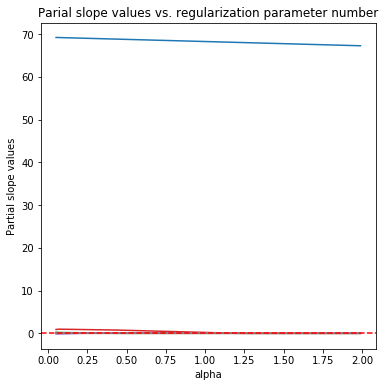

In [126]:
plot_coefs(coefs, alphas)

The intercept parameter decreases more slowly than for L2 regularization. The other parameter values are close to zero.  

Execute the code in the cell below to display the other model parameter values as the regularization parameter increases. 

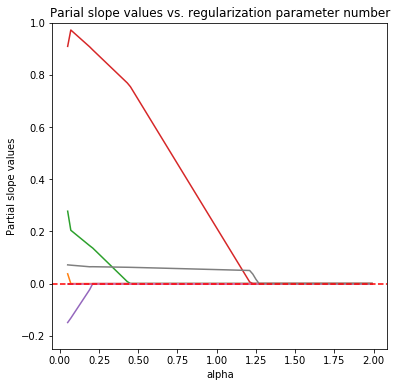

In [127]:
plot_coefs(coefs, alphas, ylim=(-0.25,1.0))

Notice that model coefficients are much more tightly constrained than for L2 regularization. Notice how the model parameters are driven to zero as the regularization parameter increases. This is typical of L1 or lasso regression as an example of the hard constraint property.



## Elastic Net Regression

DO you always need to choose between the extremes of L2 and L1 regularization? The **elastic net** algorithm uses a weighted combination of L2 and L1 regularization. As you have likely noticed, the same function is used for Lasso and Ridge regression with only the `L1_wt` argument changing. This argument determines the how much weight goes to the L1-norm of the partial slopes. If `L1_wt = 0`, the regularization is pure L2 (Ridge) and if `L1_wt = 1.0` the regularization is pure L1 (Lasso).

The code in the cell below gives equal weight to each regression method. Execute this code and examine the results.

In [101]:
alphas = np.arange(0.01, 5.0, step = 0.02)
coefs = regularized_coefs(gaulton_male, alphas, L1_wt=0.5)
coefs[:5]

array([[ 6.88846723e+01,  5.54643537e-01,  7.50207602e-01,
         2.89192281e-01, -1.90631971e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 6.81961533e+01,  3.30493431e-01,  5.41873536e-01,
         5.91583502e-01, -1.80158728e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 6.75210689e+01,  2.45428532e-01,  4.61301516e-01,
         6.95937092e-01, -1.69972828e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 6.68590296e+01,  3.26637113e-03,  2.36085396e-01,
         5.69305197e-01, -1.59999578e-01,  0.00000000e+00,
         0.00000000e+00,  4.64637249e-01],
       [ 6.62096609e+01,  0.00000000e+00,  2.28515559e-01,
         5.27660338e-01, -1.50025322e-01,  0.00000000e+00,
         0.00000000e+00,  4.98650688e-01]])

As with the L2 and L1 regularizations the intercept parameter is the largest. All other modle parameters are relatively small. 

Execute the code in the cell below to display the model parameters vs. the elastic net regularization parameter. 

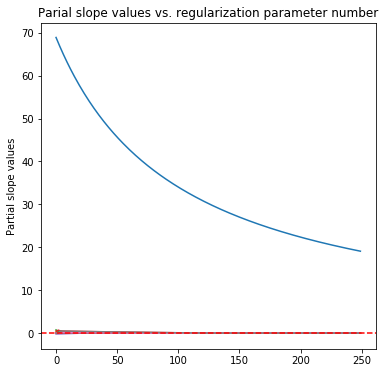

In [102]:
plot_coefs(coefs)

The intercept values decreases with the regularization parameter in a manner similar to L2 regularization.  

Now, execute the code in the cell below display how the other model parameters change with the regularization parameter.  

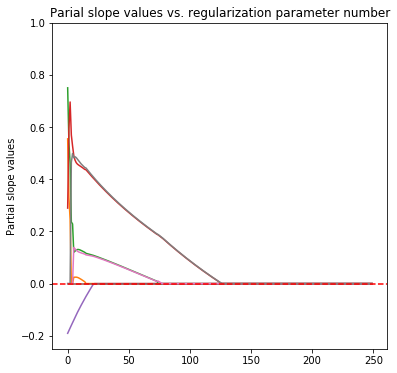

In [103]:
plot_coefs(coefs,ylim=(-0.25,1.0))

These model parameters are all being forced to 0. However, they decrease in a mostly smooth manner as the regularization parameter increases. But, there are also jumps in values of some parameters as other parameters are forced to 0. This behavior is a combination of what was observed for L2 and L1 regularizations. 

#### Copyright 2017, 2018, 2019, 2020 Stephen F Elston. All rights reserved.